In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys

sys.path.append("../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport error_correct

import glob
from tqdm import tqdm  # progress bar

In [4]:
step1_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "CTCGAGATAACTTCGTATAATGTATGCTAT",
                       post = "GGCCGGCCATAGGGCCCC",
                       length = 6)

step1_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "GAGCTCGCTAGC",
                       post = "CTCGAGATAA",
                       length = 9)

step1_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GGCCGGCCATAGGGCCCC",
                       post = "GCGGTCCA",
                       length = 16)

step1_AD = finder.Barcode(name = "AD",
                       preceder = "CACCATG",
                       post = "GGATCCG",
                       length = 162)

In [5]:
mapper = initial_map.InitialMapper(db_path = "../../duckdb/NKX2-2-full.db",
                       seq_file = ['/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/S1_czb/TL4_S1_and_gDNA_RP48hr_puro_rep1_S21.fastq.gz.assembled.fastq'],
                        bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                        design_file_path = "../../data/DNA_Tiles_nkx2_2.txt",
                      reverse_complement=False,
                        step_name = "step1")
#mapper.create_map()

In [96]:
mapper.preview_map()

step1_ADBC2_HawkBCs_RTBC_AD_initial
Total rows: 15252011


ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  RTBC_qual  \
0  CAAGAC        True  ATCGCCTTC          True  TACAGGTTATCGTCAA       True   
1  GTTAAA        True  ATAAGCGCC          True  CCAGATGCAATAGTTT       True   
2  ATTTTG        True                    False  ACGTCAACAAGTACAA       True   
3  ATAACA        True  ACGCCTGAA          True  AATATTTATCACTATT       True   
4  GCGTGT        True  CCGAATTGA          True  AATTACATAATACACG       True   

                                                  AD  AD_qual  Designed  
0  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...     True         1  
1  GCTCCCGACCTGGCCGCCGCCACCTTTCCCGCCGGCATTCCCTTCA...     True         1  
2  GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...     True         1  
3  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
4  CCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCG...     True         1

In [50]:
# mapper.generate_fastq_for_whitelist("../../data/NKX2-2_whitelist_test_function/")

In [7]:
refiner = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2-full.db",
                                    bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                                    column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                                    design_check = True, 
                                    reads_threshold = 5,
                                    map_order = [
                                        "barcode_exists",
                                        "quality",
                                        "error_corrected",
                                        "grouped",
                                        "thresholded",
                                        "unique_target",
                                        "designed"
                                    ],
                                    step_name = "step1",
                                 design_file = "../../data/DNA_Tiles_nkx2_2.txt",
                                        should_check_exists = False, 
                                         plot_histograms = True,
                                        min_fraction = 0.9,
                                        descriptor = "overlap_prop")
refiner

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_

Using the following step order:
1. initial
2. barcode_exists
3. quality
4. error_corrected
5. grouped
6. thresholded
7. unique_target
8. designed



Removing rows with null or empty barcodes (excluding AD)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 3.16 seconds.


Filtering to high-quality reads...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_quality — filtered for TRUE in all *_qual columns.
Done in 4.15 seconds.


=== Running error correction step on step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_quality ===

=== Applying whitelist for step1 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/NKX2-2/error_corrected/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq
Wrote 2915005 reads to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/NKX2-2/error_corrected/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq
Done in 3.64 seconds.

Whitelist already exists, skipping:
  /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/NKX2-2/error_corrected/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.txt
Unique canonical barcodes: 1757


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 4.78 seconds.

Whitelist application complete for step1 at step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_error_corrected
Done in 18.20 seconds.

Grouping step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_error_corrected...


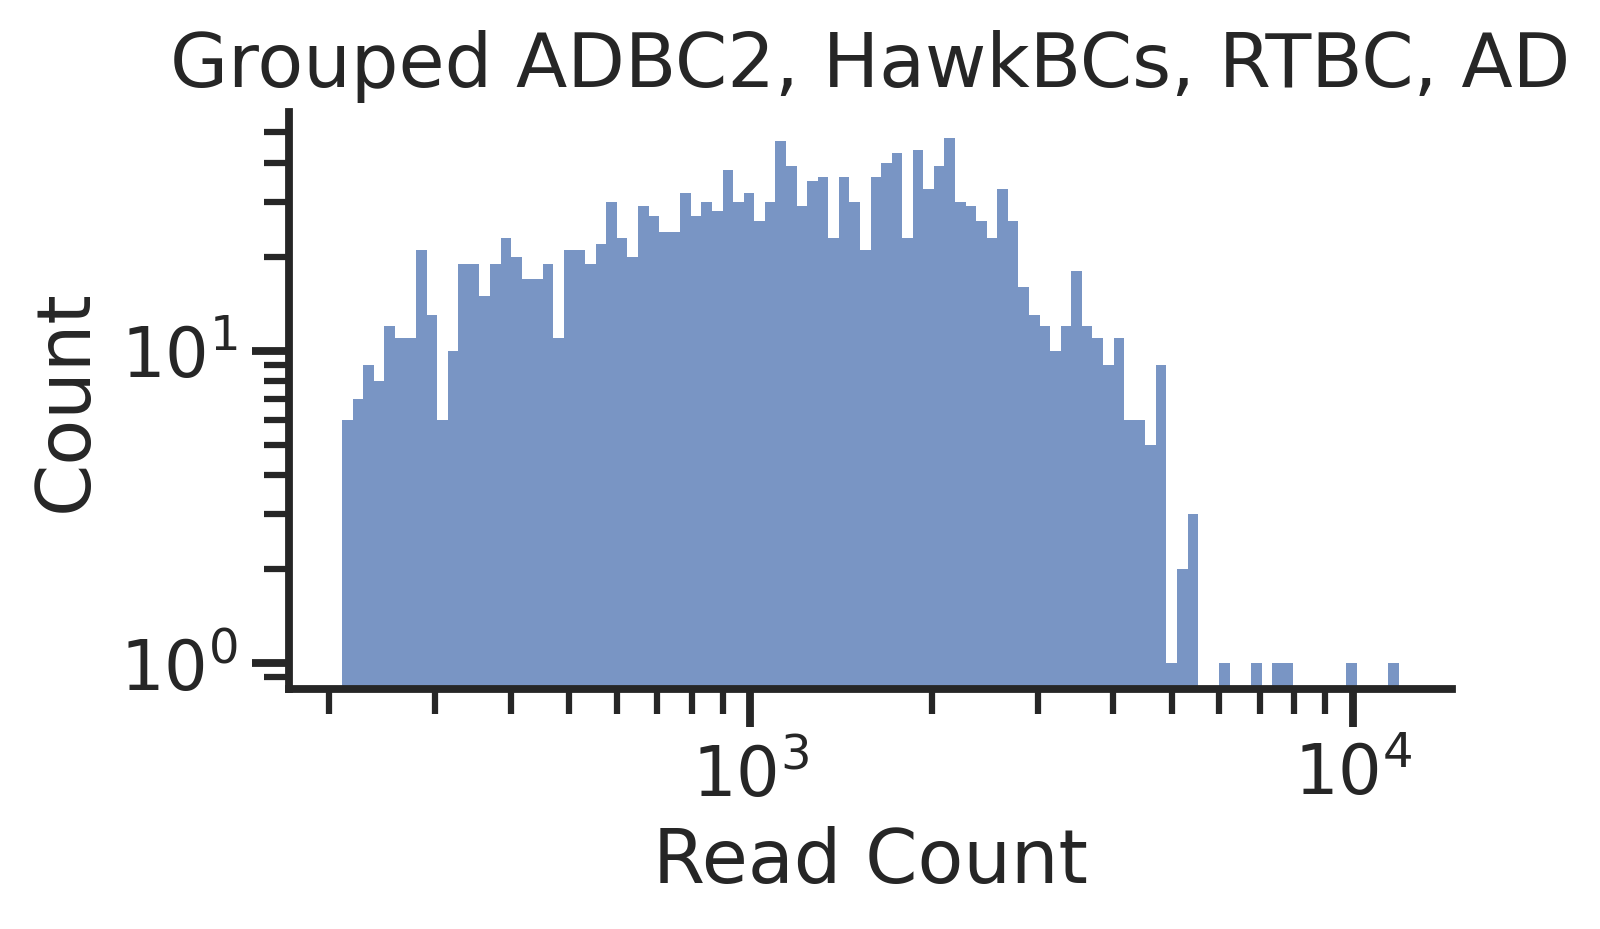

Done in 0.58 seconds.

Thresholding...
Using reads threshold of 5.


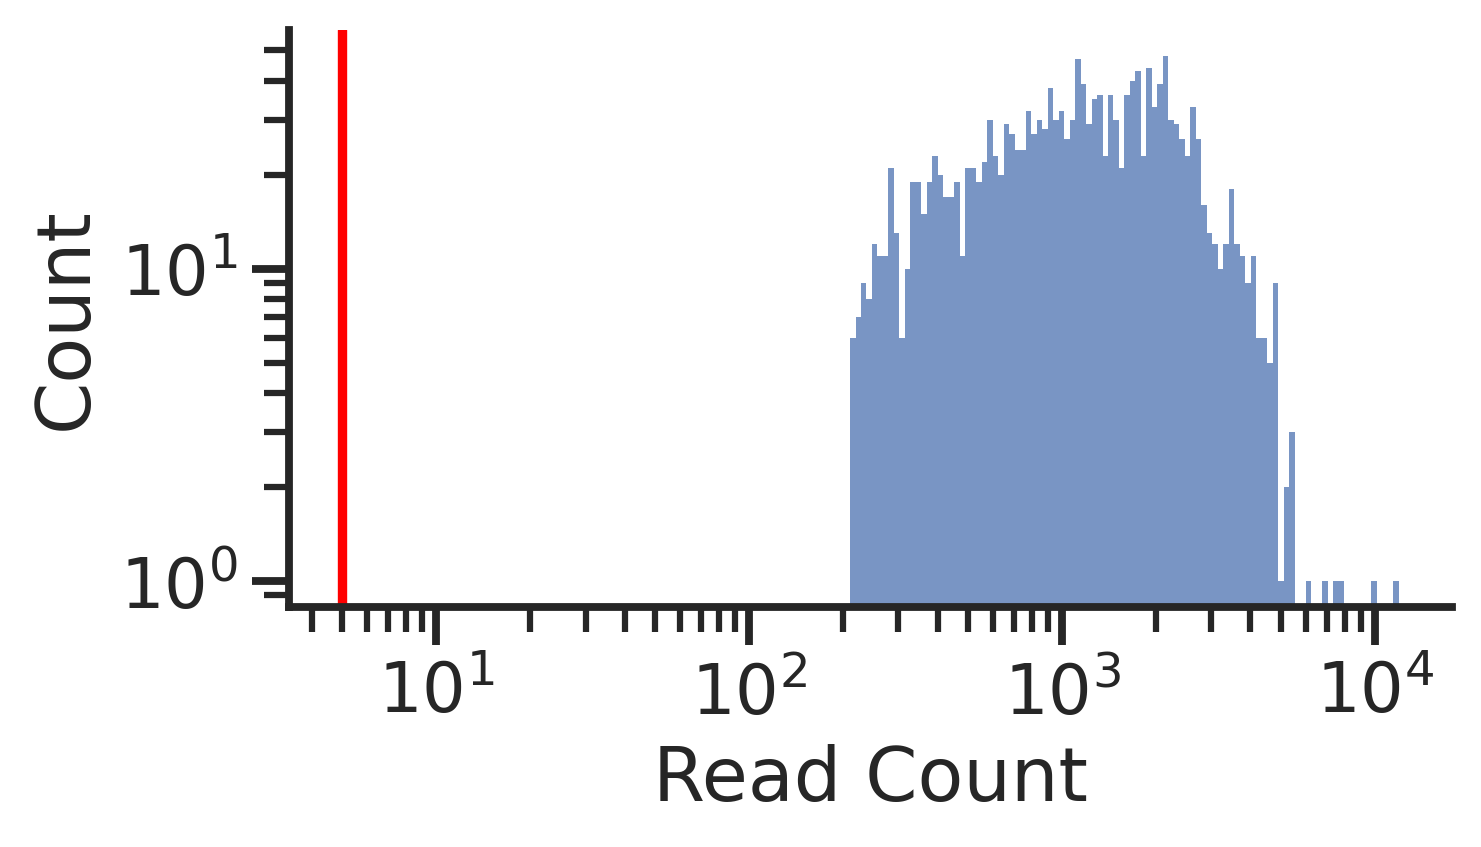

Done in 0.52 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: ADBC2 || '-' || HawkBCs → AD
	Processing mapping 2: RTBC → ADBC2 || '-' || HawkBCs
Created filtered table: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_unique_target
Done in 0.03 seconds.


Filtering to designed sequences...
Created table: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_designed — kept only Designed == 1.
Done in 0.01 seconds.

Done.


In [98]:
refiner.refine_map_from_db()

In [99]:
error_corrected = refiner.get_map_df('error_corrected')
error_corrected

ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  \
0        TCAAGT        True  CAGATCGTT          True  AACTAAATATGAAATA   
1        CAAACT        True  AACCTACGC          True  TTAAAAATGACTTGCA   
2        GGGATA        True  ATGAACTCC          True  GTAAAAAATTTAAAGG   
3        TAAAGA        True  ACAAGTGGA          True  AGTTGATTGATTAATA   
4        AAAGTT        True  CATGTTGCC          True  AAAATTATTGAGAAGC   
...         ...         ...        ...           ...               ...   
2509543  GGATTA        True  ACCTGGAAC          True  GTCGCATGACATAGAT   
2509544  AGGACG        True  CAGTTACAC          True  ACTCCAAAACATGTTA   
2509545  ATAACC        True  ATAGGAAGG          True  GCAAGTAAGCGCTCTT   
2509546  TCATAT        True  CAATCTCTC          True  AACAGGAAACATGAAT   
2509547  TTGGTC        True  ATAGCACAC          True  TAGGAGGAATTACAAA   

         RTBC_qual                                                 AD  \
0             True  GCCCAGGACGCCGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
1             True  GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...   
2             True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCACCTTCA...   
3             True  GCCCAGGACCTGGCCCTGGCCACCTTCCAGGCCGGCATTCCCTTCA...   
4             True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
...            ...                                                ...   
2509543       True  GCCCAGGACCTGGCCAGCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2509544       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2509545       True  GCCCAGAAGCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2509546       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGTTCGGCATTCCCTTCA...   
2509547       True  GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...   

         AD_qual  Designed  
0           True         1  
1           True         1  
2           True         1  
3           True         1  
4           True         1  
...          ...       ...  
2509543     True         0  
2509544     True         0  
2509545     True         0  
2509546     True         0  
2509547     True         0  

[2509548 rows x 9 columns]

In [100]:
# error_corrected[["ADBC2", "HawkBCs", "RTBC", "AD"]].drop_duplicates()

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.16 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

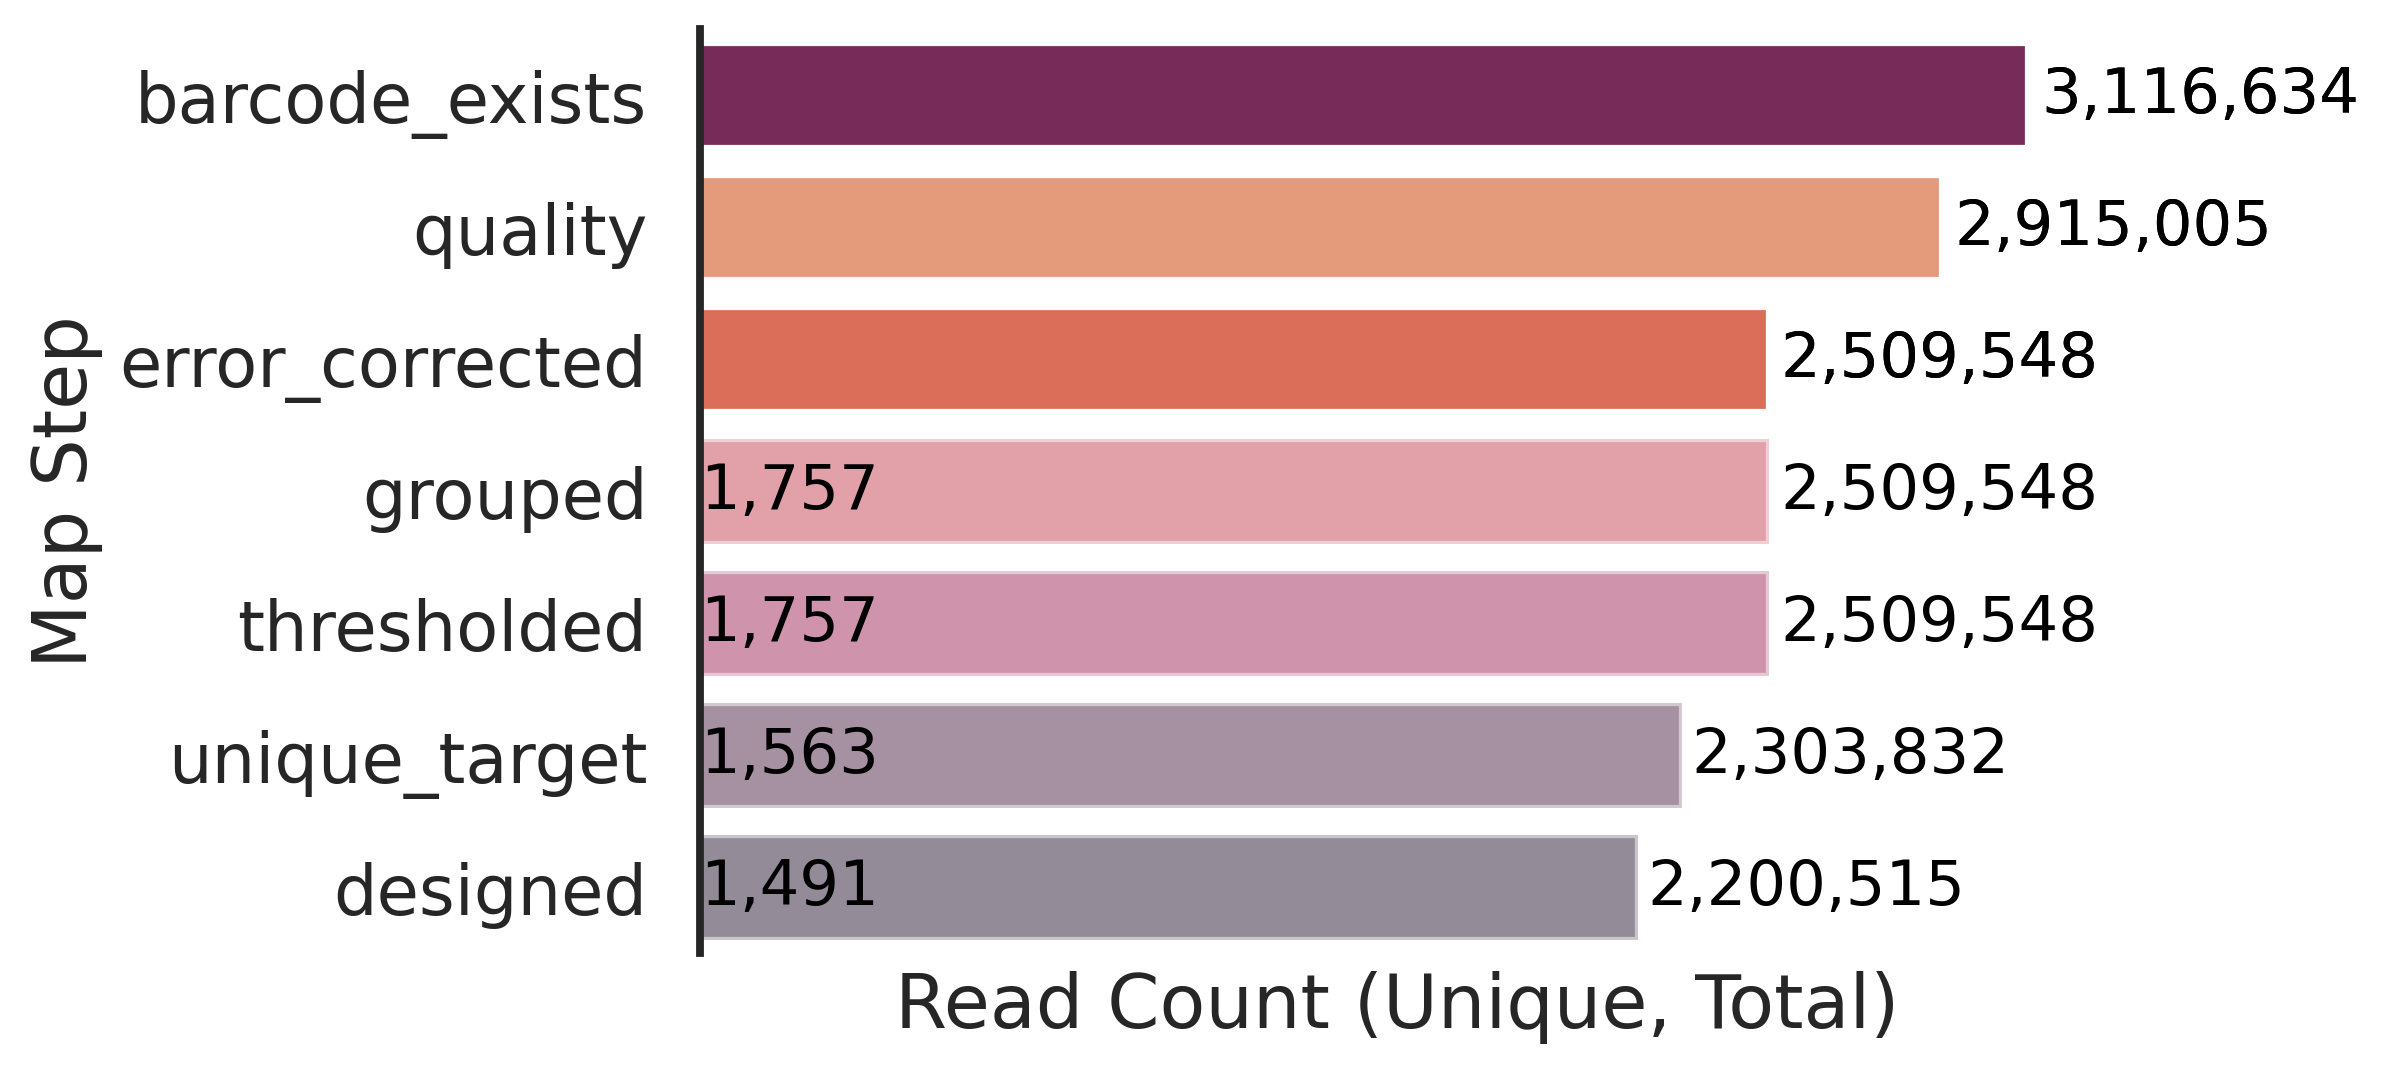

In [101]:
refiner.plot_loss()
#ax.set_xscale('log')

['error_corrected/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.txt']


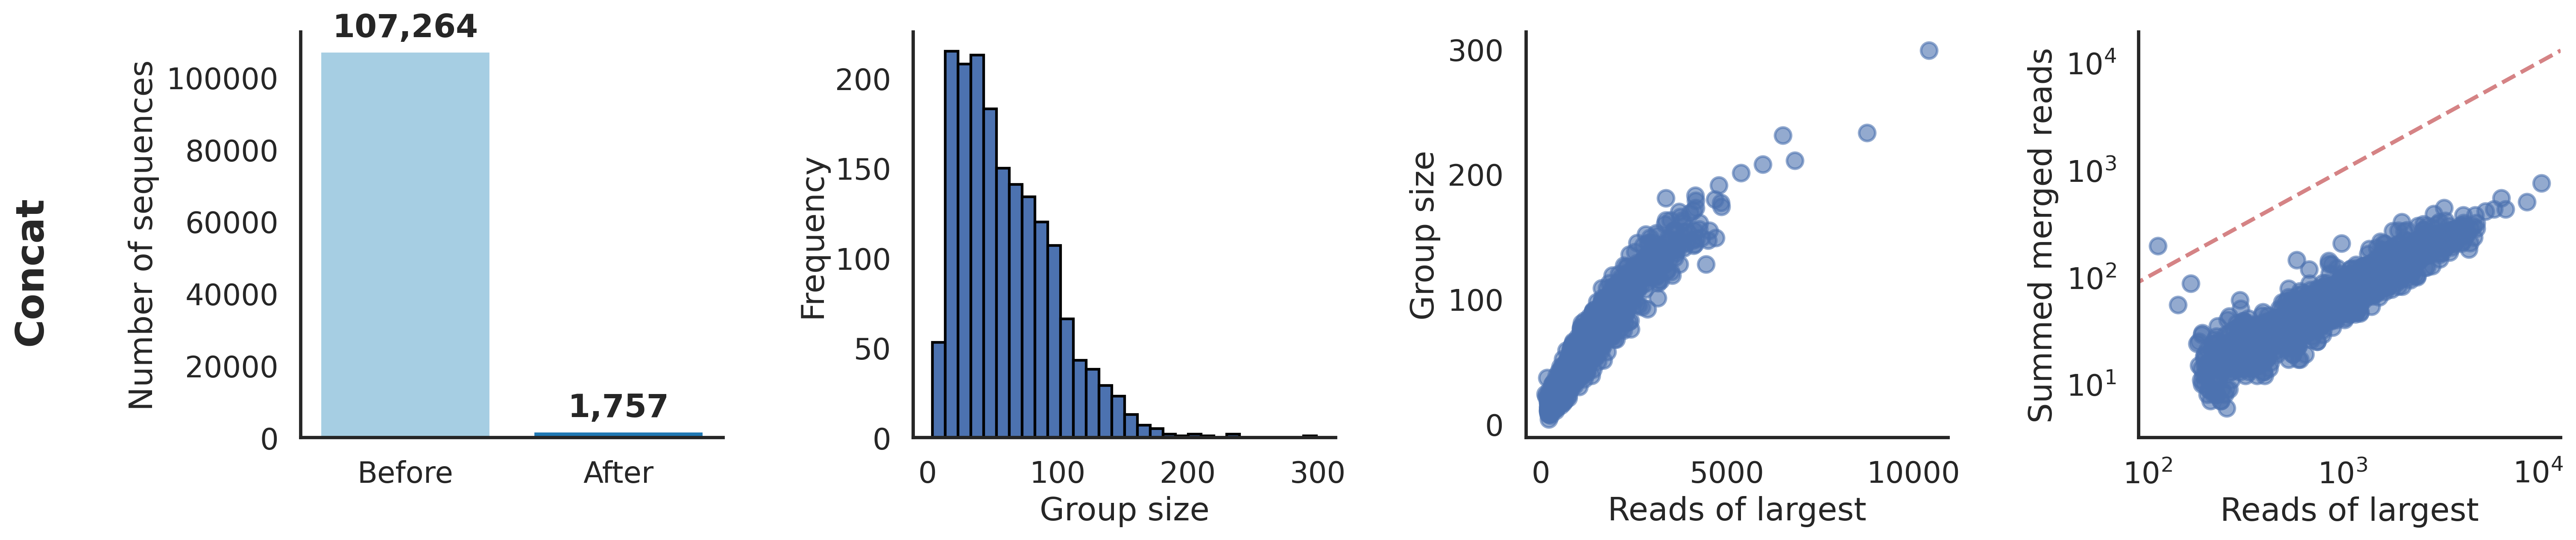

Done in 2.08 seconds.



In [8]:
refiner.plot_error_correction()

In [ ]:
refiner.get_map_df('step1_ADBC2_HawkBCs_RTBC_AD_filtered').drop_duplicates()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [101]:
refiner.get_map_df('error_corrected').drop_duplicates()

ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  \
0        GTACAA        True  AGTTCTAGG          True  AGACCAATTCCGTTTT   
2        AATCGA        True  CCACCTTAC          True  CAACCAGAGGCGTCTG   
3        TAACAG        True  CATCCACTA          True  GATCGGGACTACTTGC   
4        TATTAT        True  CCATTCTGC          True  TTCCTTGGGCAGGCGG   
5        CAGACT        True  CATGTTGCC          True  ATTAAATATAGTTTAC   
...         ...         ...        ...           ...               ...   
1653321  ACACGC        True  ACGACTGTG          True  GTGGTACGAGAATCAG   
1742167  GCACCA        True  ACTCCACAT          True  GTAAAGAAGAAATGTC   
1745581  CGGCAA        True  ATAGGAAGG          True  GCAAGTAAGCGCTCTT   
2232117  TTCCGC        True  CACTATGCA          True  AACTCGAATGGTATTA   
2243025  TGCATG        True  ATGTTGAGG          True  CAATAATTTTTTGTTC   

         RTBC_qual                                                 AD  \
0             True  GCCCAGGACCTGGCCGCCGCTCCCTTCCAGGCCGGCATTCCCTTCA...   
2             True  CCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCGAGG...   
3             True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
4             True  CCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCG...   
5             True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
...            ...                                                ...   
1653321       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
1742167       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
1745581       True  GCCCAGAAGCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2232117       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTTC...   
2243025       True  GCCCAGGACCTGGCCGCCGCCGAGTTCCAGGCCGGCATTCCCTTCA...   

         AD_qual  Designed  
0           True         0  
2           True         0  
3           True         0  
4           True         1  
5           True         1  
...          ...       ...  
1653321     True         1  
1742167     True         1  
1745581     True         1  
2232117     True         1  
2243025     True         1  

[3469 rows x 9 columns]

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.14 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

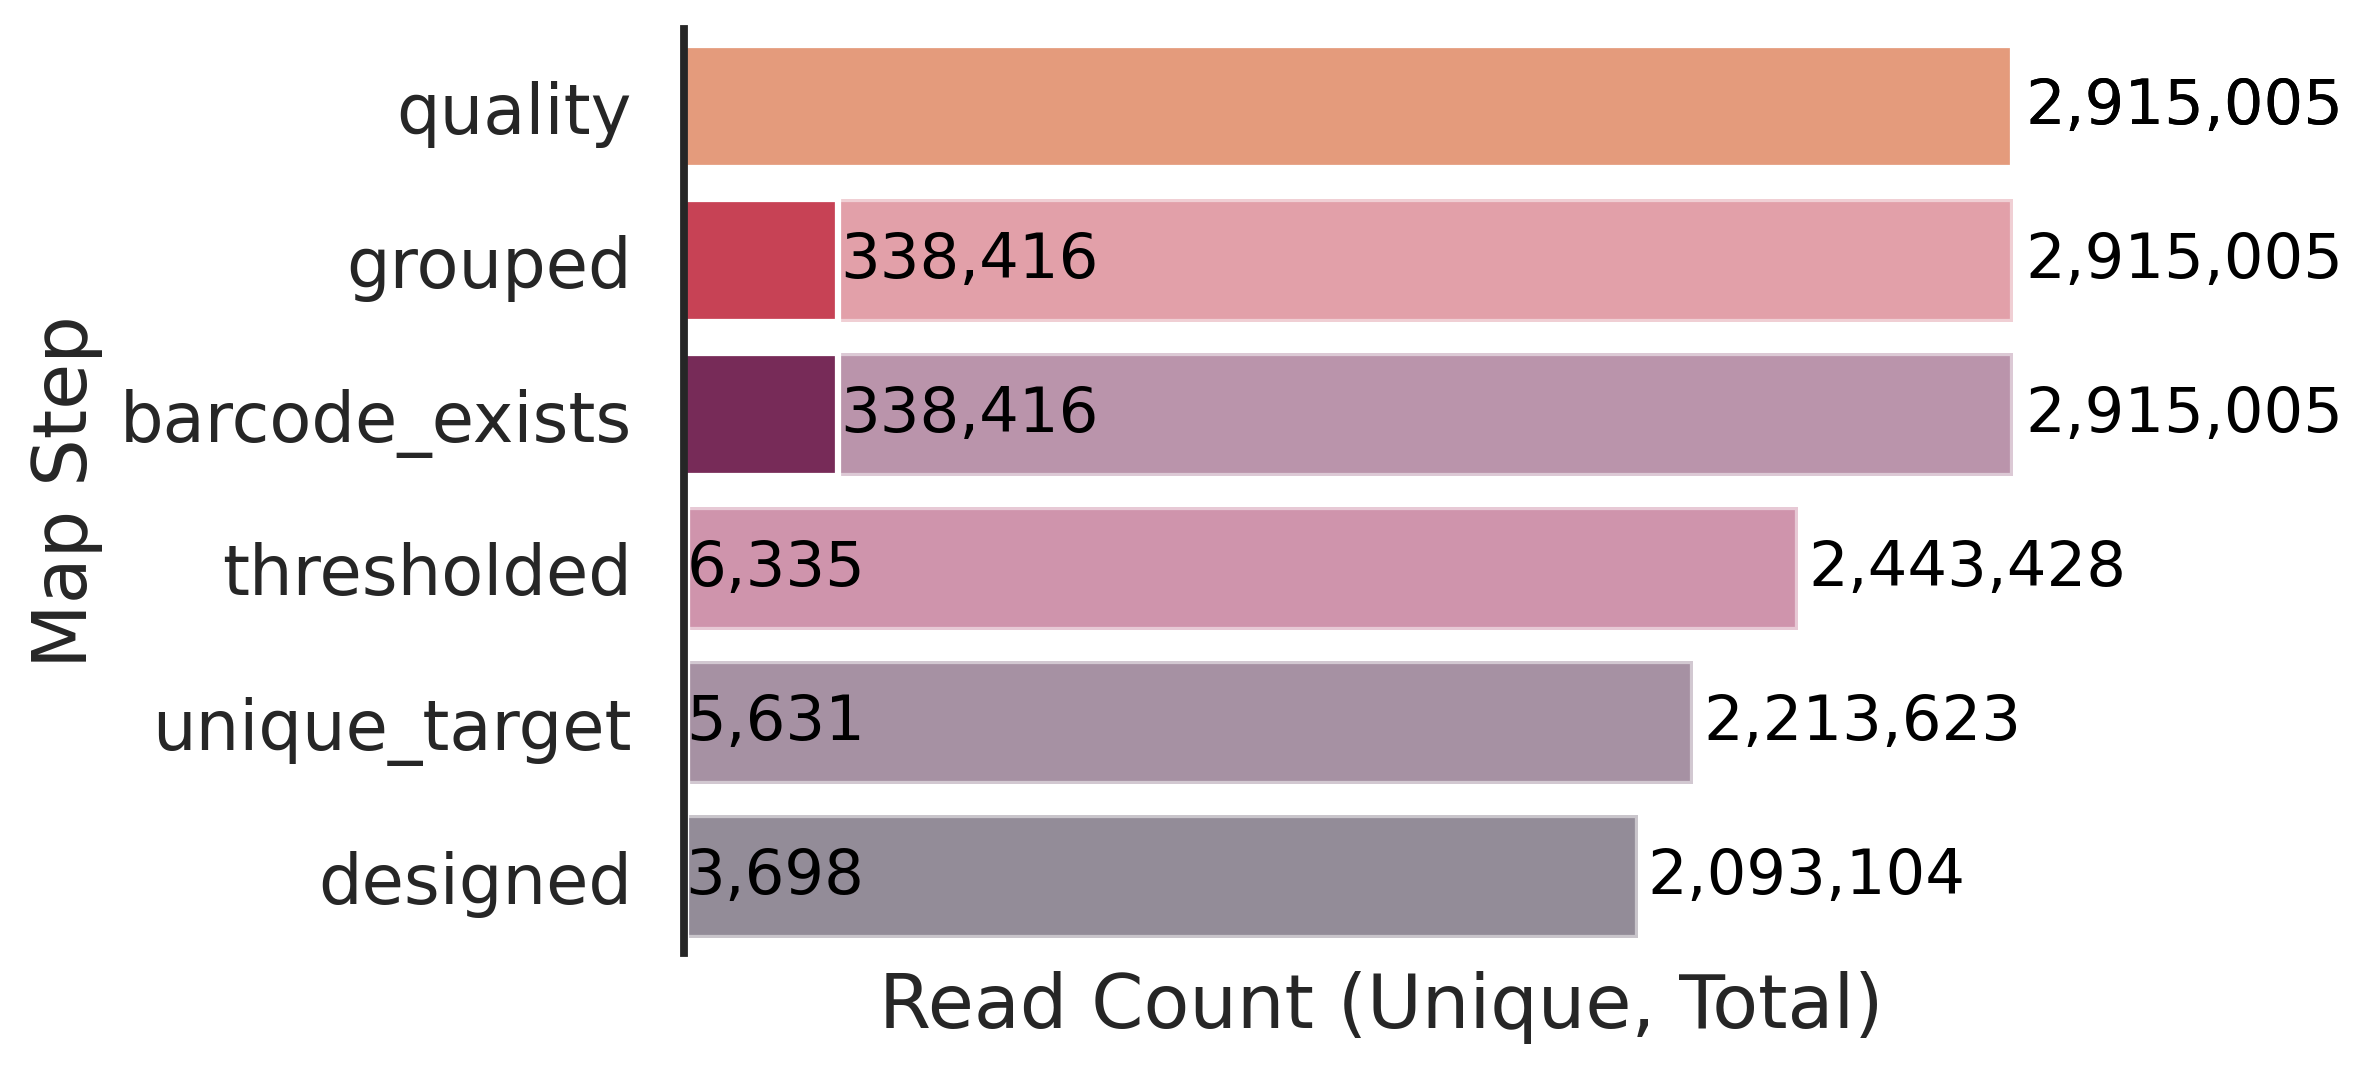

In [58]:
refiner.plot_loss()

In [28]:
refiner.get_map_df('quality')

ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  \
0        TAACGT        True  CATCTTAGG          True  CAAAACGTAGCTTCTG   
1        TTTACG        True  ACCTGGAAC          True  GTGAGCGAAGTCTCCC   
2        CCCGAT        True  CCATTCTGC          True  CACTACGAAAGTCATA   
3        CCGAGA        True  ACCGGATGT          True  TGCGACCGTTAAGAGC   
4        CCGAGA        True  ACCGGATGT          True  TGCGACCGTTAAGAGC   
...         ...         ...        ...           ...               ...   
2915000  CTCGAT        True  CACAAGGAC          True  TAACATACTAGTGAGA   
2915001  AGATAG        True  CATTCCAAG          True  CTGGGCCCCAATAGAA   
2915002  TGTTTA        True  CATTCGTAC          True  GGGCATAGGCTTGACA   
2915003  AATGTC        True  AACAGAGTC          True  AATTATTTCCTACATT   
2915004  TAAGAA        True  ACGACTGTG          True  AAACTCCCCGGACACA   

         RTBC_qual                                                 AD  \
0             True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
1             True  GCCCAGGACCTGGCCAGCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2             True  CCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCG...   
3             True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
4             True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
...            ...                                                ...   
2915000       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCTGTTCA...   
2915001       True  ACCGCCTTCATCGCCGCCGCCGTGCTGATGAGCCTGGTGATCGCCA...   
2915002       True  ACCGACTTCATCGACGAGGAGGTGTTCATGAGCTTCGTGATCGAGA...   
2915003       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2915004       True  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   

         AD_qual  Designed  
0           True         1  
1           True         1  
2           True         1  
3           True         1  
4           True         1  
...          ...       ...  
2915000     True         1  
2915001     True         1  
2915002     True         1  
2915003     True         1  
2915004     True         1  

[2915005 rows x 9 columns]

In [6]:
mapper.apply_whitelist("../../data/NKX2-2_whitelist_test_function/")


=== Applying whitelist for step1 ===
Generating FASTQ: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Wrote 2915005 reads to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq
Done in 17.34 seconds.



TypeError: run_whitelist_concat_domains() missing 1 required positional argument: 'self'

In [16]:
error_correct.run_whitelist_concat_domains("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq",
                                           "../../data/NKX2-2_whitelist_test_function/")

Running umi_tools whitelist on step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted.fastq ...
Whitelist complete.
- Log: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.log
- Output: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.txt
- Plots: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_plots_*.png
Done in 2.90 minutes.



/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/umi_tools/lib/python3.12/site-packages/umi_tools/whitelist_methods.py:207: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig3.set_xlim(0, len(counts)*1.25)



{'log': PosixPath('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.log'),
 'whitelist': PosixPath('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.txt'),
 'plot_prefix': PosixPath('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_plots')}

In [17]:
error_correct.convert_txt_to_whitelist_mapping_df_from_path('/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_whitelist_test_function/step1_ADBC2_HawkBCs_RTBC_AD_filtered_barcodes_extracted_whitelist.txt')

original  \
0       AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...   
1       AAAAAAAACCACATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...   
2       AAAAAAAACCCCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...   
3       AAAAAAAACCGCATAGATAGTGGGATATAGAGCCCAGGACCTGGCC...   
4       AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...   
...                                                   ...   
107259  TTTTTTAGAGGAGTTTGATCGTAGGTGCATGGCCCAGGACCTTGCC...   
107260  TTTTTTAGAGTAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...   
107261  TTTTTTAGATGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...   
107262  TTTTTTAGGGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...   
107263  TTTTTTATAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...   

                                                canonical  
0       AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...  
1       AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...  
2       AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...  
3       AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...  
4       AAAAAAAACCGCATAGATGGTGGGATATAGAGCCCAGGACCTGGCC...  
...                                                   ...  
107259  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...  
107260  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...  
107261  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...  
107262  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...  
107263  TTTTTTAGAGGAGTTGGATCGTAGGTGCATGGCCCAGGACCTTGCC...  

[107264 rows x 2 columns]

In [6]:
error_correct.run_whitelist_parallel( barcodes = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                                     input_fastq = '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/S1_czb/TL4_S1_and_gDNA_RP48hr_puro_rep1_S21.fastq.gz.assembled.fastq',
                                     output_dir = "../../data/NKX2-2_whitelist_test_function")

Done in 0.00 seconds.

Generating whitelist for ADBC2...
Generating whitelist for HawkBCs...
Generating whitelist for RTBC...
Generating whitelist for AD...
Done in 3.59 minutes.

Whitelist generated for ADBC2 at ../../data/NKX2-2_whitelist_test_function/ADBC2_whitelist.txt
Done in 3.64 minutes.

Whitelist generated for AD at ../../data/NKX2-2_whitelist_test_function/AD_whitelist.txt
Done in 3.82 minutes.

Whitelist generated for RTBC at ../../data/NKX2-2_whitelist_test_function/RTBC_whitelist.txt
Done in 3.97 minutes.

Whitelist generated for HawkBCs at ../../data/NKX2-2_whitelist_test_function/HawkBCs_whitelist.txt


['Whitelist generated for ADBC2 at ../../data/NKX2-2_whitelist_test_function/ADBC2_whitelist.txt',
 'Whitelist generated for AD at ../../data/NKX2-2_whitelist_test_function/AD_whitelist.txt',
 'Whitelist generated for RTBC at ../../data/NKX2-2_whitelist_test_function/RTBC_whitelist.txt',
 'Whitelist generated for HawkBCs at ../../data/NKX2-2_whitelist_test_function/HawkBCs_whitelist.txt']

In [9]:
error_correct.convert_txt_to_whitelist_mapping_df(step1_HawkBCs,
                                     output_dir = "../../data/NKX2-2_whitelist_test_function")

original  canonical
0     AACAACACC  AACAACACC
1     AAAAACACC  AACAACACC
2     AACAAAACC  AACAACACC
3     AACAACAAC  AACAACACC
4     AACAACACA  AACAACACC
...         ...        ...
4118  CCGTTCAGG  CCGTTCAGA
4119  CCGTTCATA  CCGTTCAGA
4120  CCGTTCGGA  CCGTTCAGA
4121  CCTTTCAGA  CCGTTCAGA
4122  TCGTTCAGA  CCGTTCAGA

[4123 rows x 2 columns]

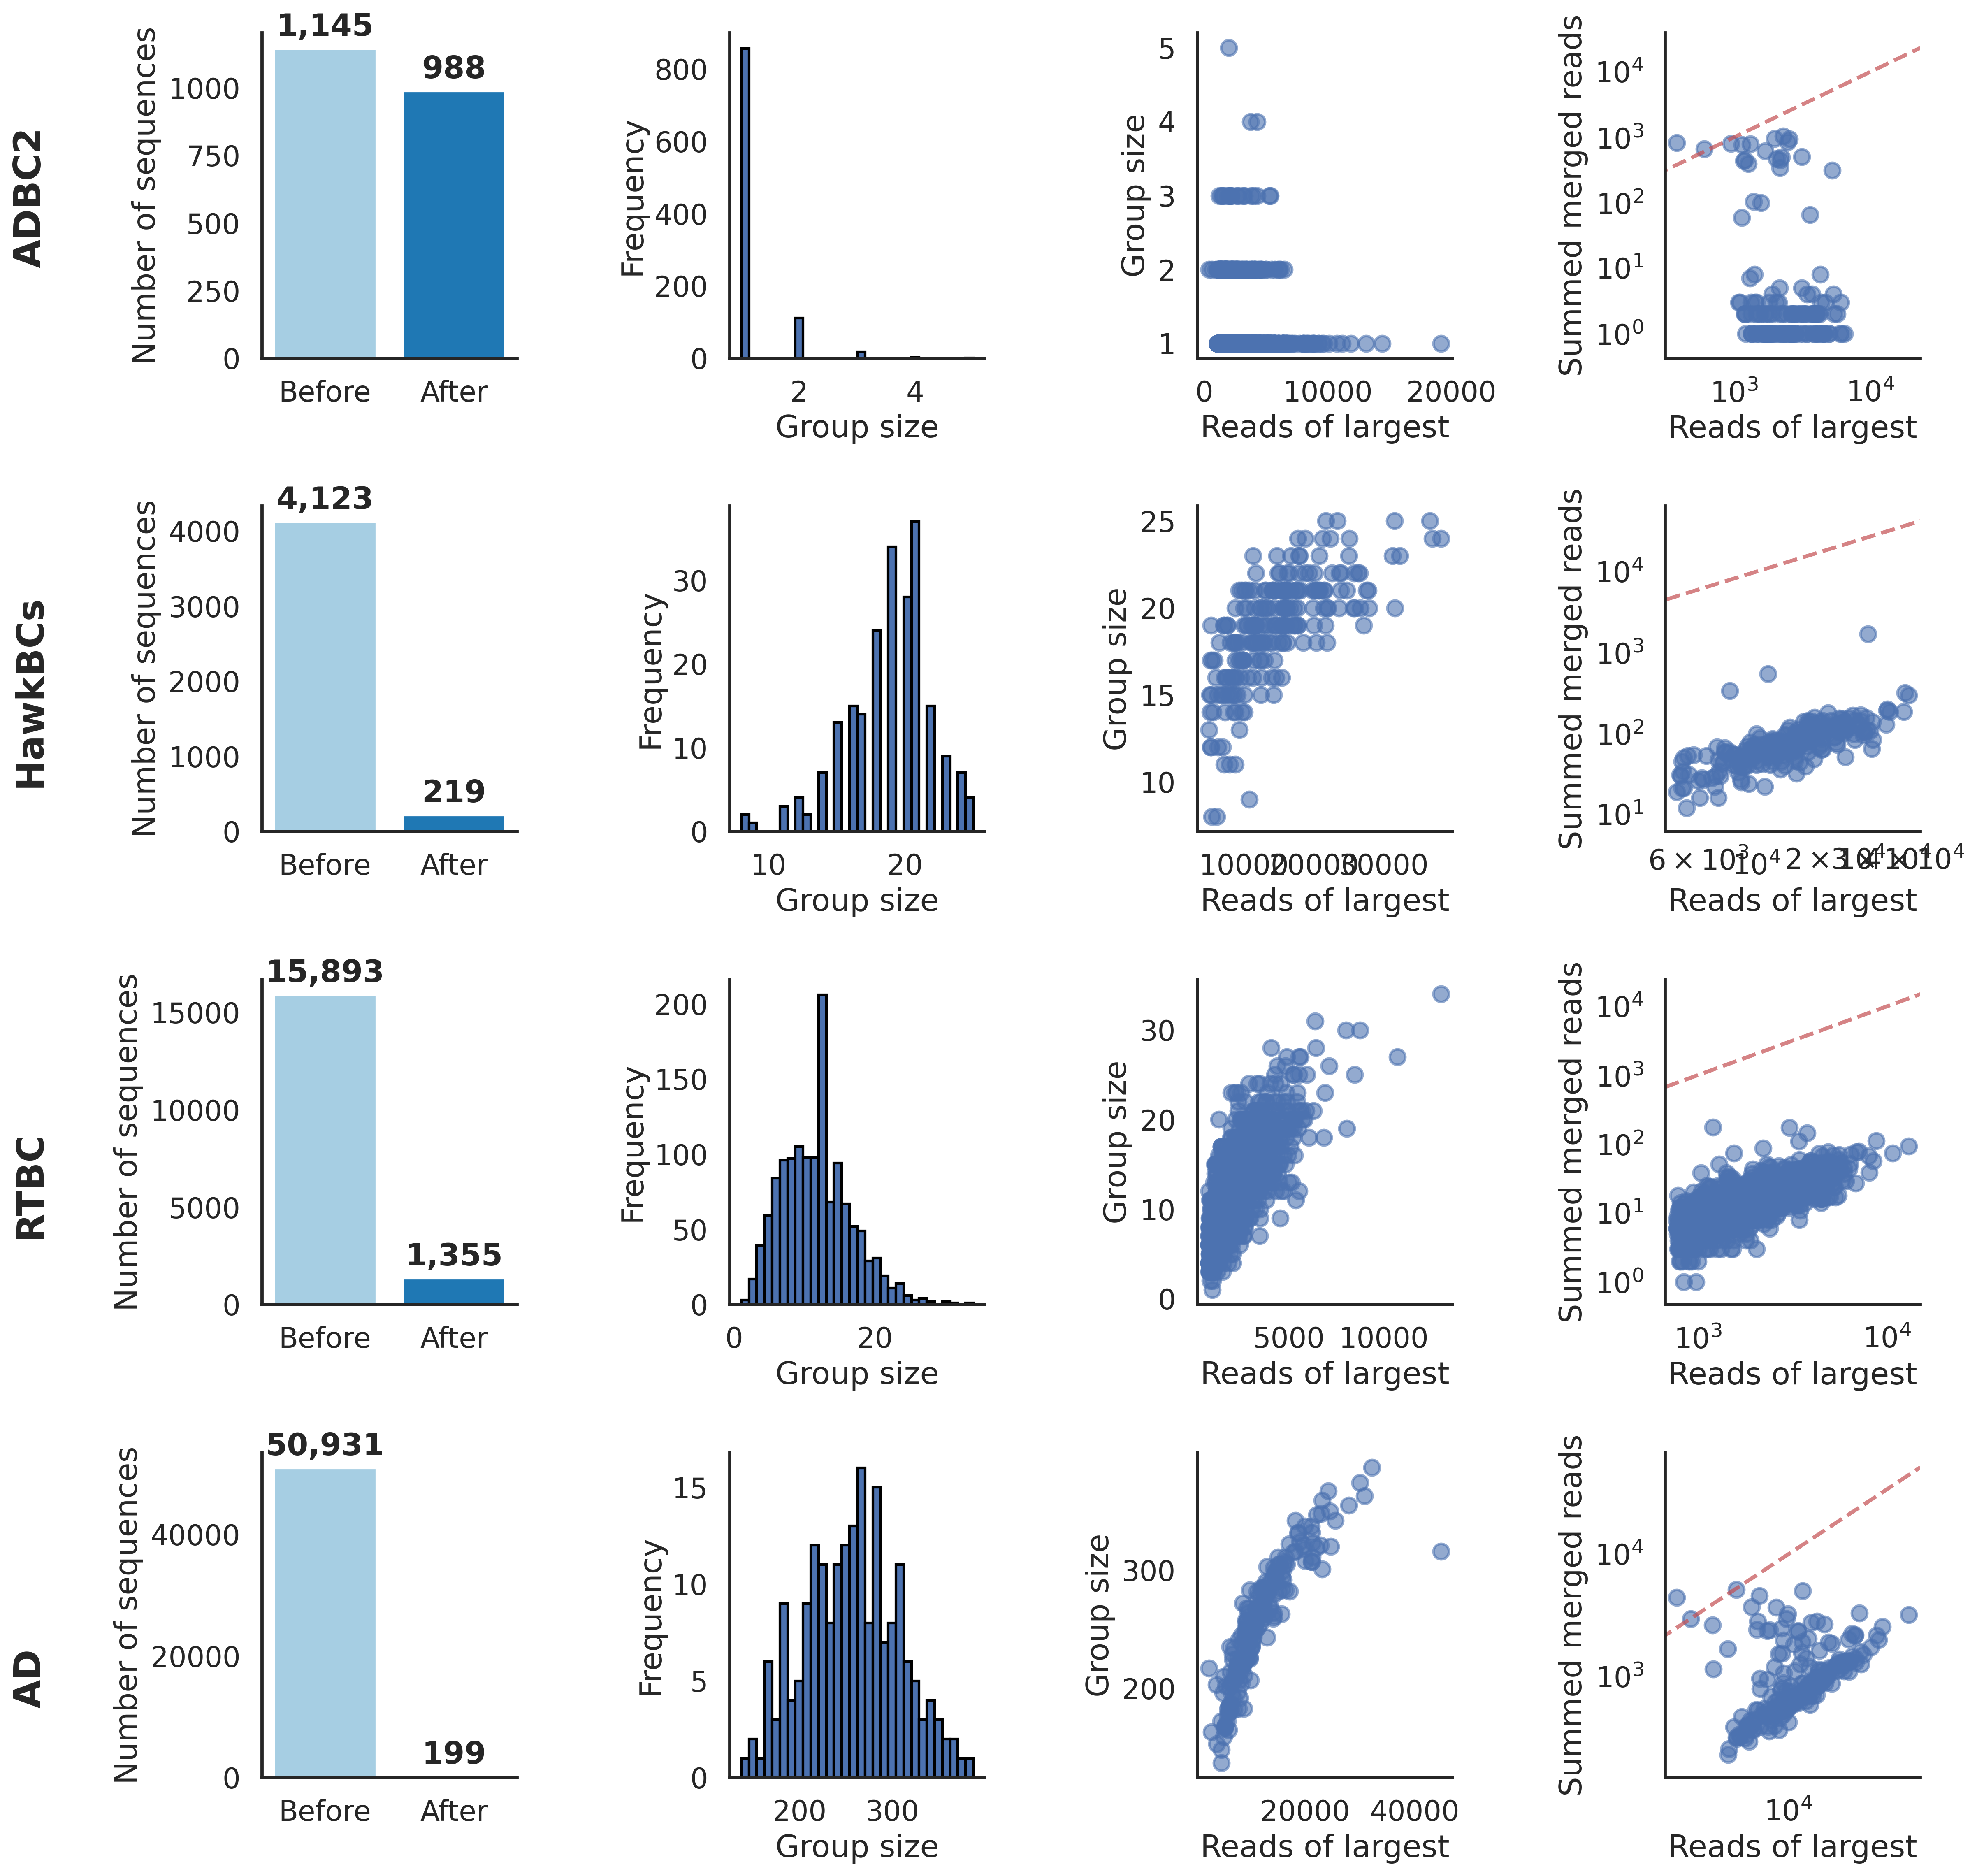

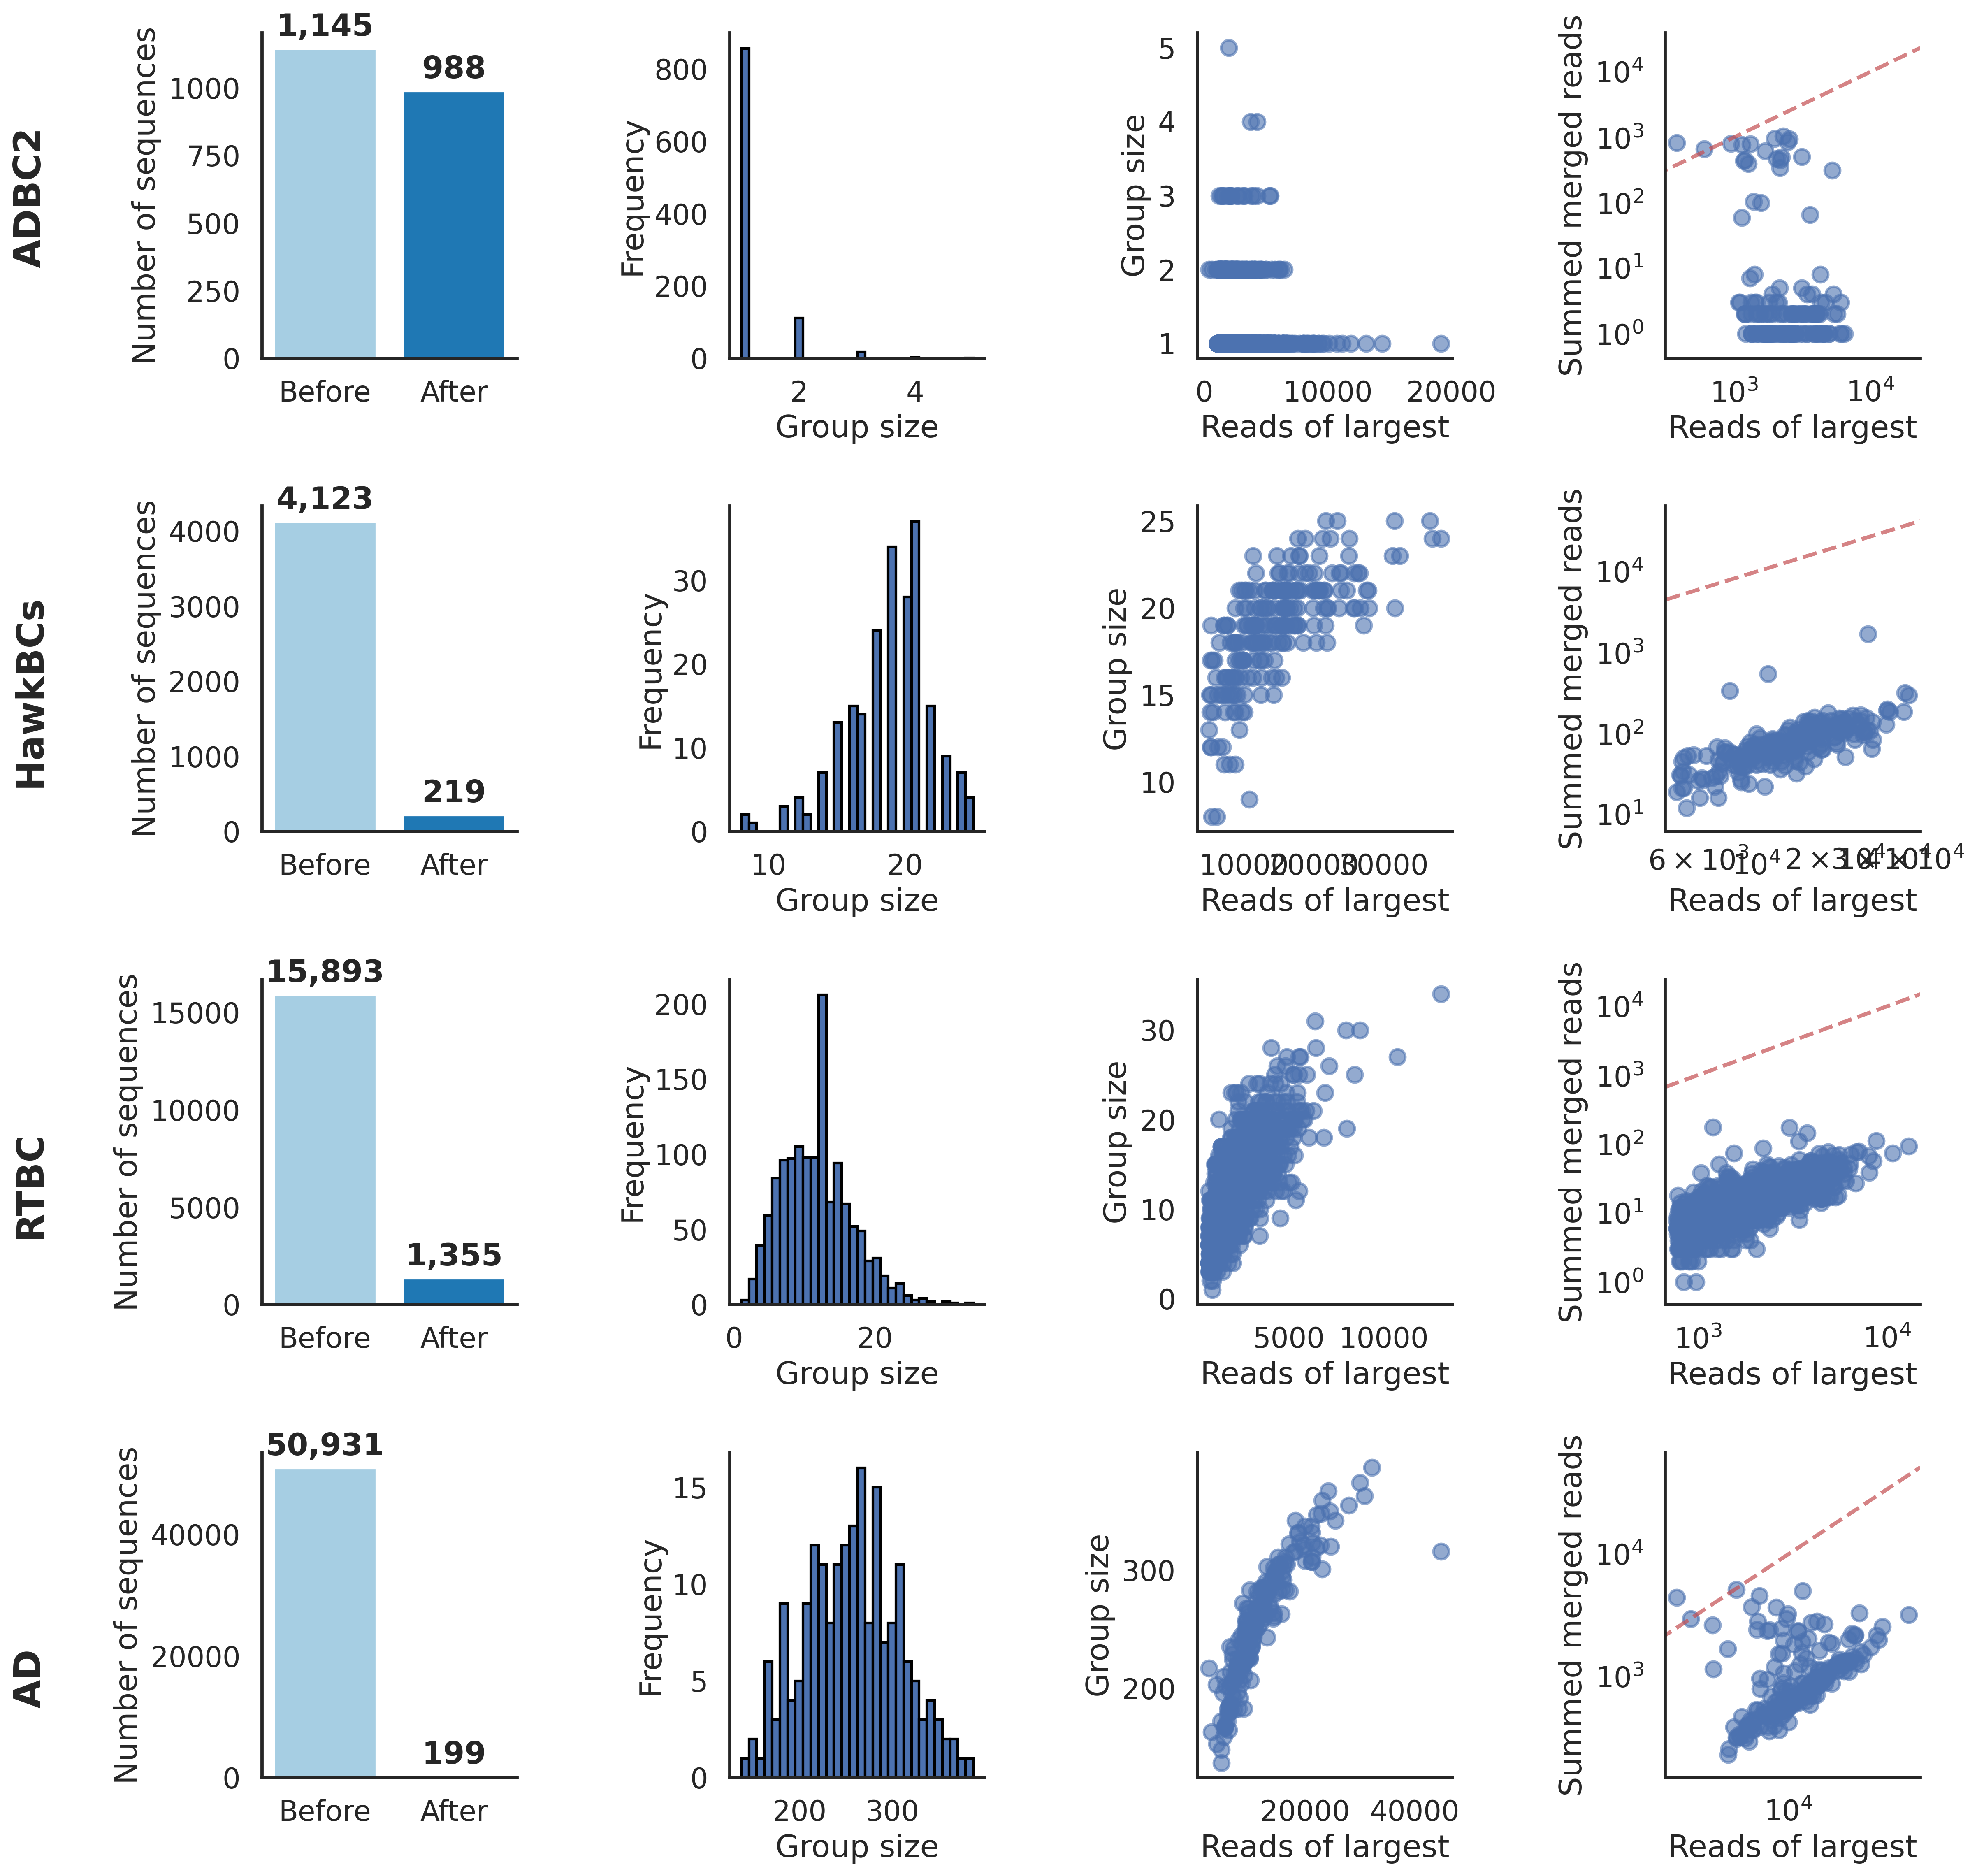

In [17]:
error_correct.plot_all_whitelists(barcodes = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                                   output_dir = "../../data/NKX2-2_whitelist_test_function") 

In [18]:
mapper = initial_map.InitialMapper(db_path = "../../duckdb/NKX2-2_full_whitelist.db",
                                   seq_file = ['/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/S1_czb/TL4_S1_and_gDNA_RP48hr_puro_rep1_S21.fastq.gz.assembled.fastq'],
                        design_file_path = "../../data/DNA_Tiles_nkx2_2.txt",
                        bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                      reverse_complement=False,
                                  step_name = "step1")

mapper.create_map()

Reading 1 FASTQ/TXT file(s)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 29.07 seconds.

Done in 0.00 seconds.

Extracting 4 barcodes...
CTCGAGATAACTTCGTATAATGTATGCTAT(.*)GGCCGGCCATAGGGCCCC
GAGCTCGCTAGC(.*)CTCGAGATAA
GGCCGGCCATAGGGCCCC(.*)GCGGTCCA
CACCATG(.*)GGATCCG
Done in 9.71 seconds.

Extracting UMIs (0 bases)...
Done in 0.00 seconds.

Merging with design file...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 6.01 seconds.

Mapping complete.


In [65]:
mapper.preview_map()

step1_ADBC2_HawkBCs_RTBC_AD_initial
Total rows: 15252011


ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  RTBC_qual  \
0  TAACGT        True  CATCTTAGG          True  CAAAACGTAGCTTCTG       True   
1  TTTACG        True  ACCTGGAAC          True  GTGAGCGAAGTCTCCC       True   
2  CCCGAT        True  CCATTCTGC          True  CACTACGAAAGTCATA       True   
3  CCGAGA        True  ACCGGATGT          True  TGCGACCGTTAAGAGC       True   
4  CCGAGA        True  ACCGGATGT          True  TGCGACCGTTAAGAGC       True   

                                                  AD  AD_qual  Designed  
0  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
1  GCCCAGGACCTGGCCAGCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
2  CCTCCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCG...     True         1  
3  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
4  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

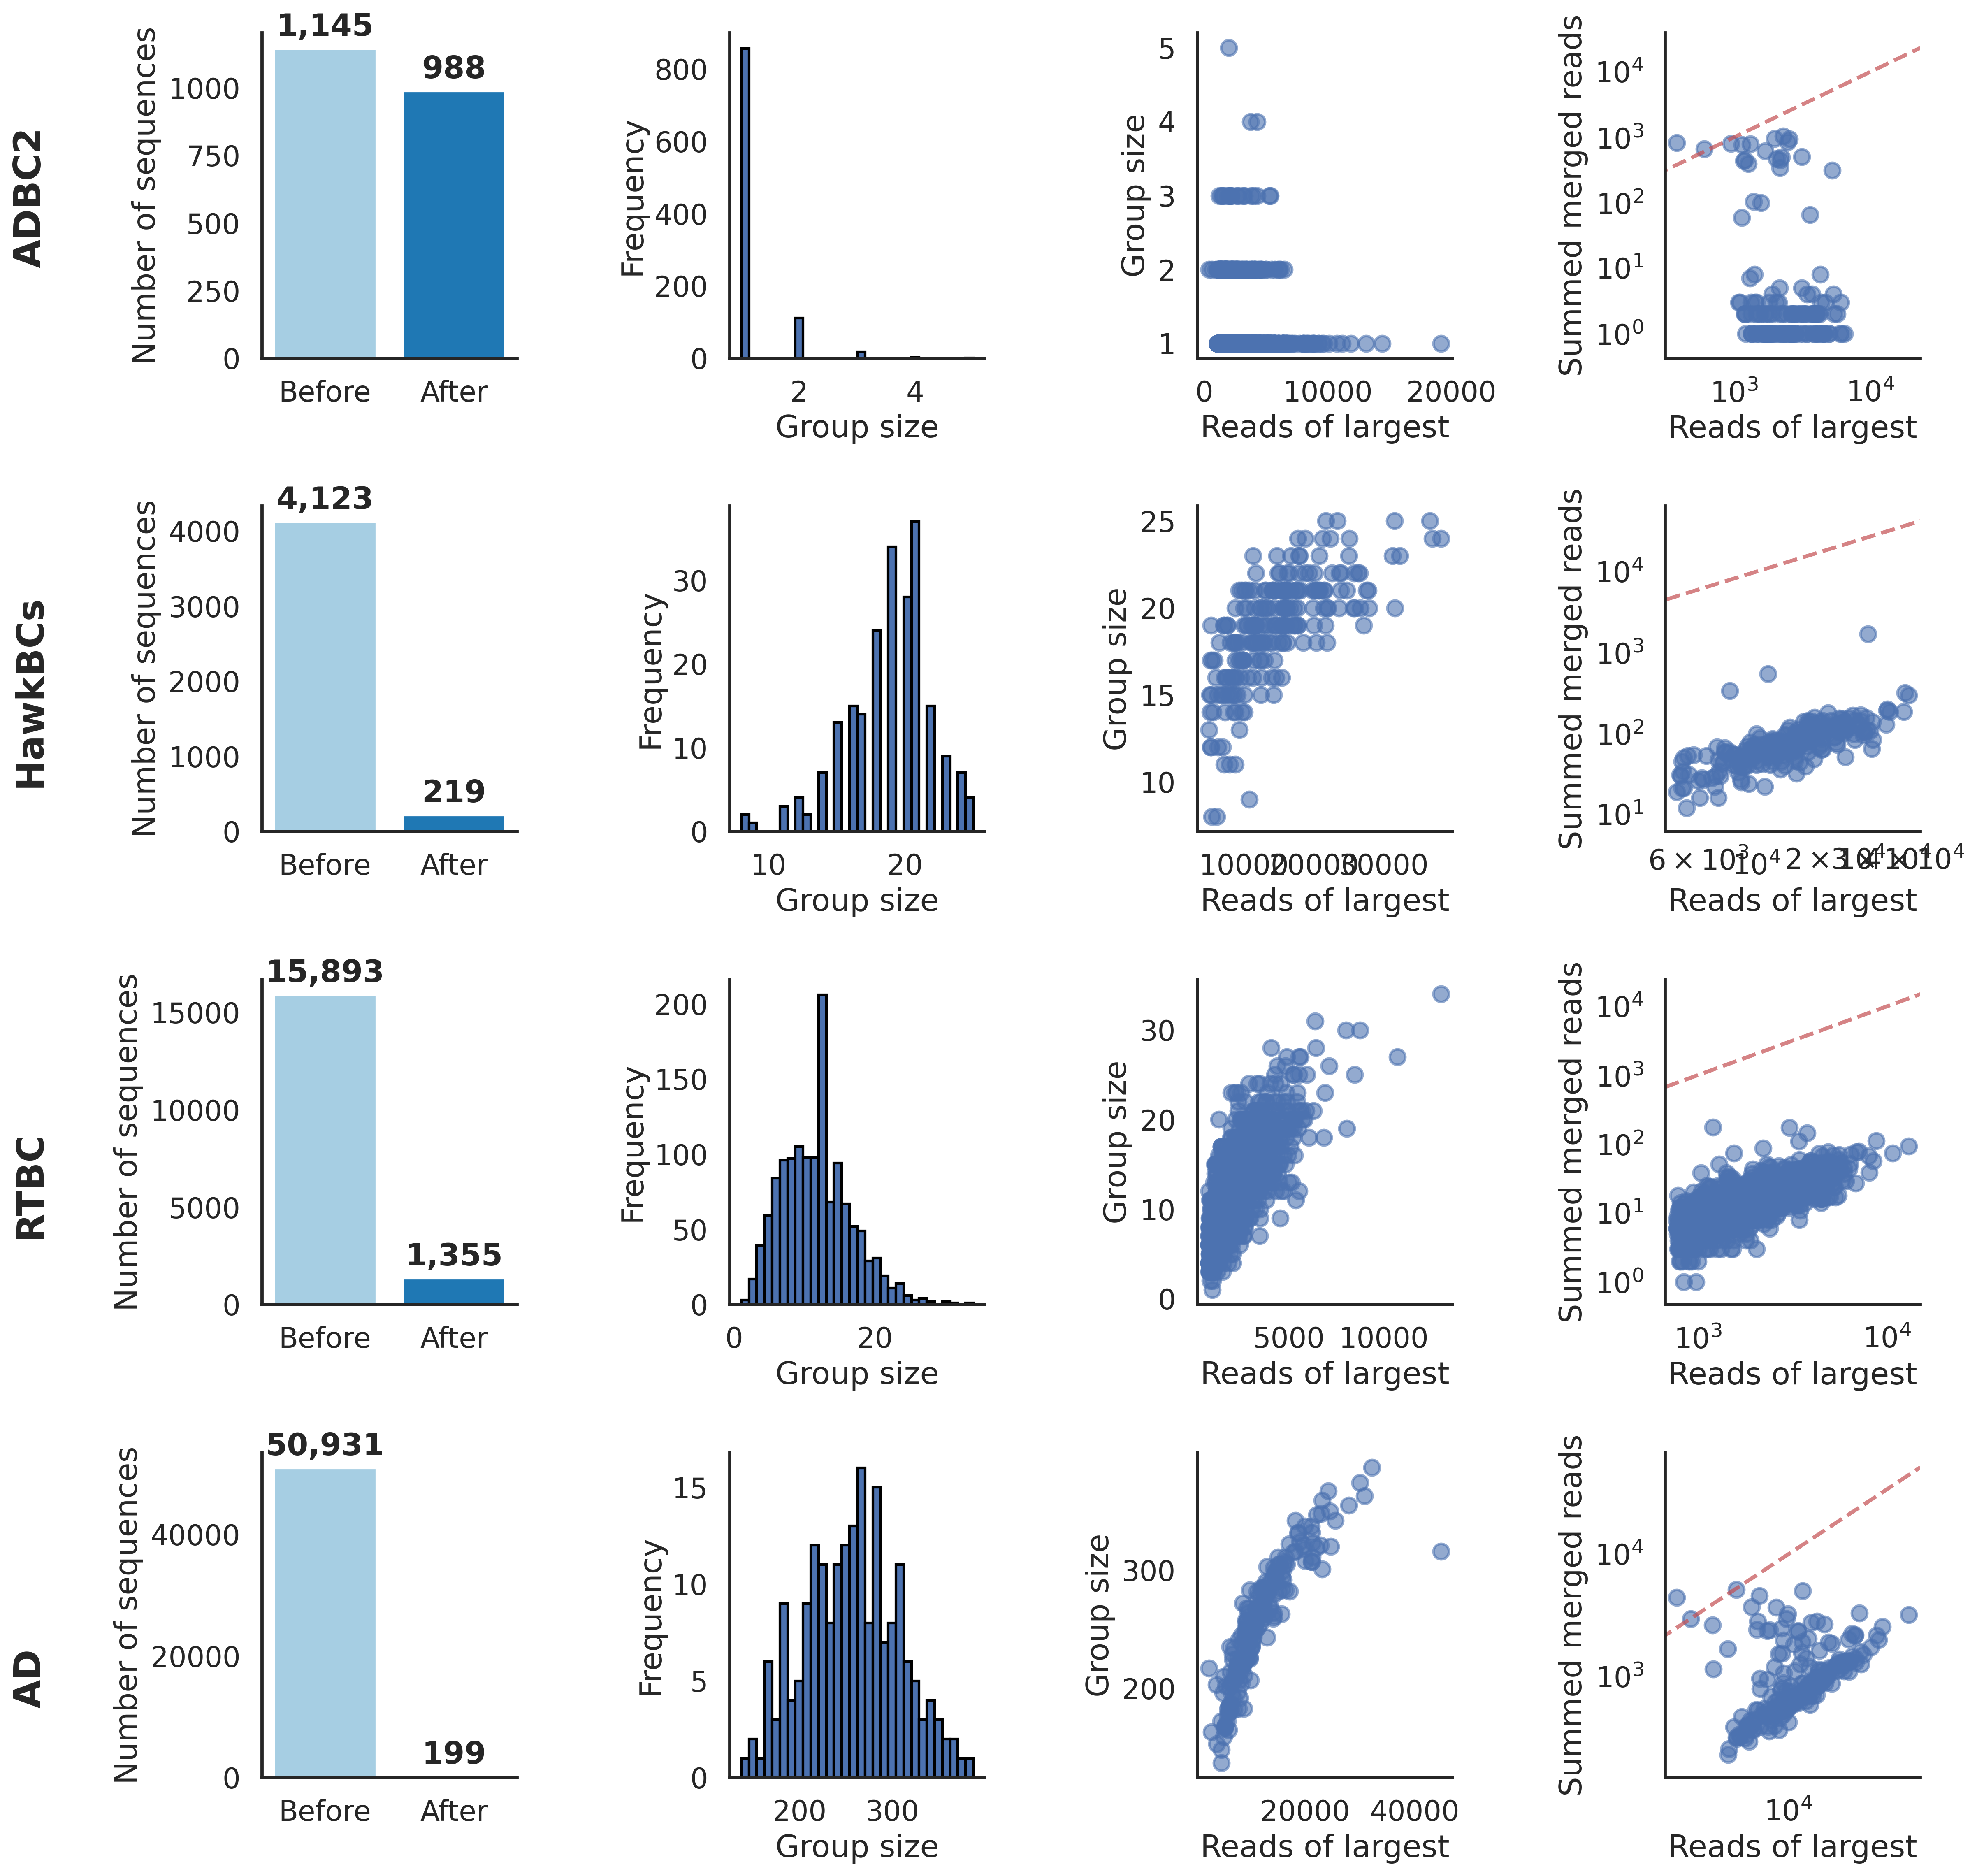

In [70]:
mapper.apply_whitelist("../../data/NKX2-2_whitelist_test_function/")

In [71]:
mapper.preview_map()

step1_ADBC2_HawkBCs_RTBC_AD_initial
Total rows: 2862614


ADBC2  ADBC2_qual    HawkBCs  HawkBCs_qual              RTBC  RTBC_qual  \
0  GTAGGA        True  ATTCGGTTC          True  AATAACCTGAGGGTCA       True   
1  CAGAAA        True  ACTTCCTCT          True  GCTGGAAAATCGTATT       True   
2  TGGGTA        True  ACCGACAAC          True  CTCACTACGATTACGT       True   
3  CCTATG        True  AAGTCTCAC          True  CTTACGCAGATGACTA       True   
4               False                    False  CCGAAAGCAAGAGGGC       True   

                                                  AD  AD_qual  Designed  
0  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
1  GCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCA...     True         1  
2  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1  
3  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...     True         1  
4  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...     True         1

In [72]:
refiner = map_refiner.MapRefiner(db_path = "../../duckdb/NKX2-2_full_whitelist.db",
                     bc_objects = [step1_ADBC2, step1_HawkBCs, step1_RTBC, step1_AD],
                     column_pairs = [(("ADBC2", "HawkBCs"), "AD"), ( "RTBC", ("ADBC2", "HawkBCs"))],
                        design_check = True, 
                         reads_threshold = 5,
                        map_order = ['grouped', 'barcode_exists', 'thresholded', 'unique_target', 'quality_designed'],
                        step_name = "step1",
                                should_check_exists = False, plot_histograms = True,
                                min_fraction = 0.9,
                                descriptor = "overlap_prop")
refiner

Base prefix (stable across descriptors): step1_ADBC2_HawkBCs_RTBC_AD_
Full prefix for this instance: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_

Using the following step order:
1. initial
2. grouped
3. barcode_exists
4. thresholded
5. unique_target
6. quality_designed



Grouping step1_ADBC2_HawkBCs_RTBC_AD_initial...


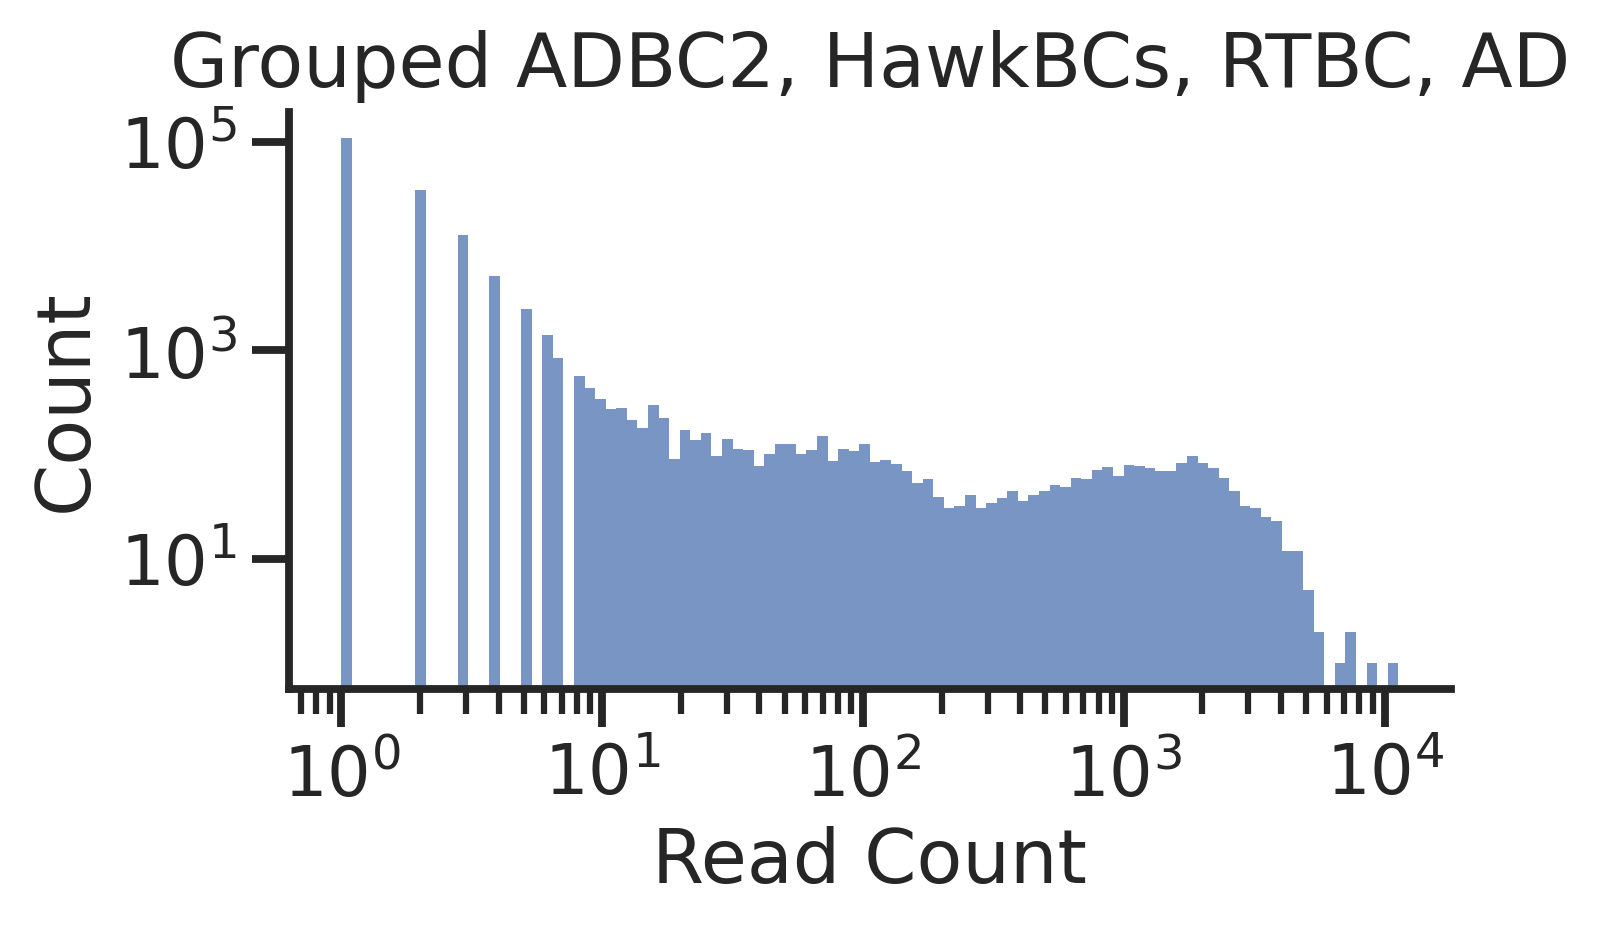

Done in 0.74 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.21 seconds.

Thresholding...
Using reads threshold of 5.


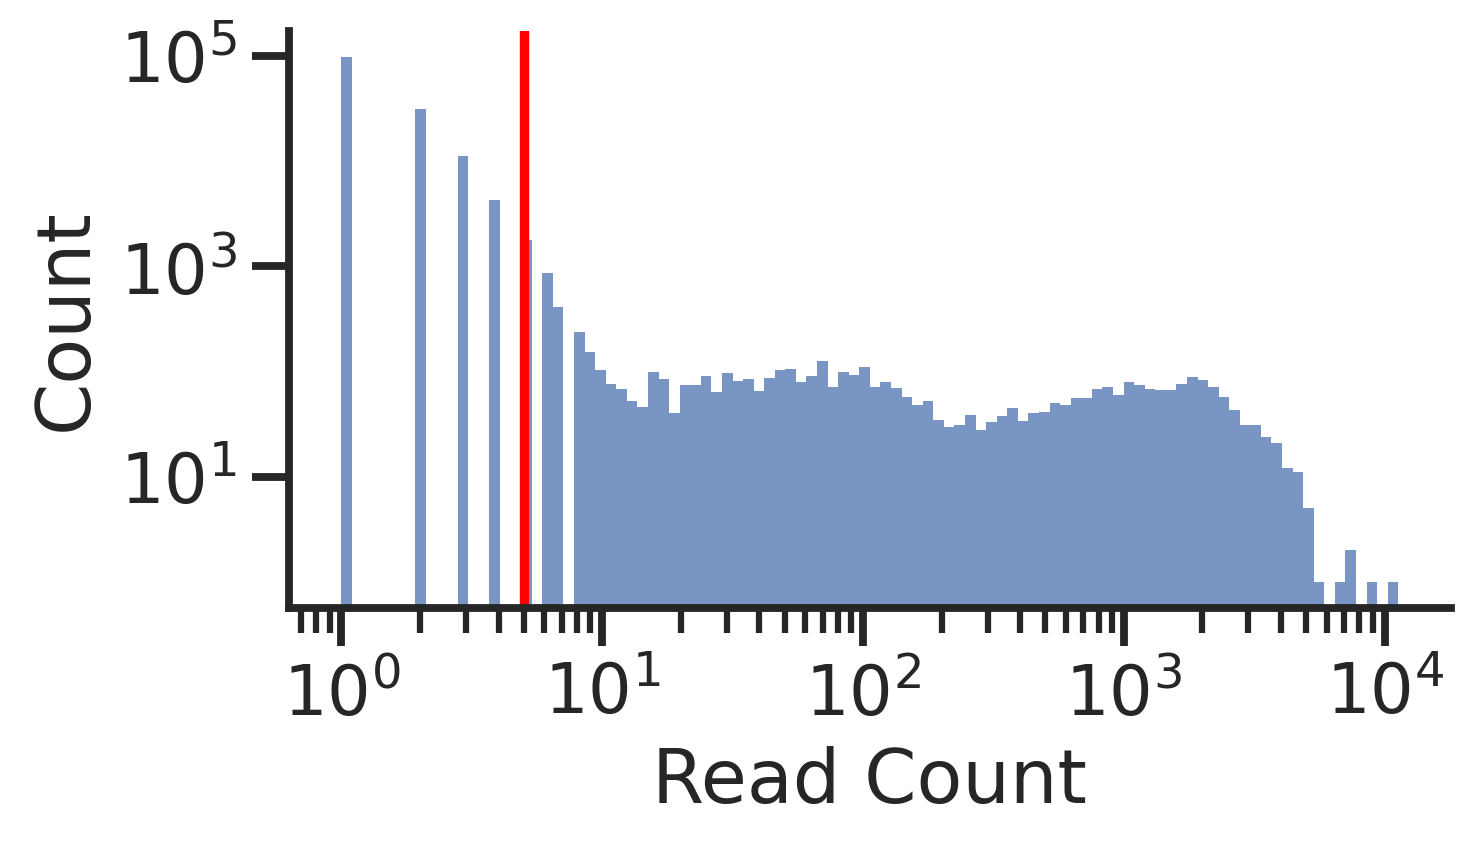

Done in 0.46 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: ADBC2 || '-' || HawkBCs → AD
	Processing mapping 2: RTBC → ADBC2 || '-' || HawkBCs
Created filtered table: step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_unique_target
Done in 0.03 seconds.

Filtering to quality and designed...
Done in 0.01 seconds.

Done.


In [75]:
refiner.refine_map_from_db()

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.03 seconds.

Saved loss summary table as 'step1_ADBC2_HawkBCs_RTBC_AD_overlap_prop_loss_summary'
Done in 0.03 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

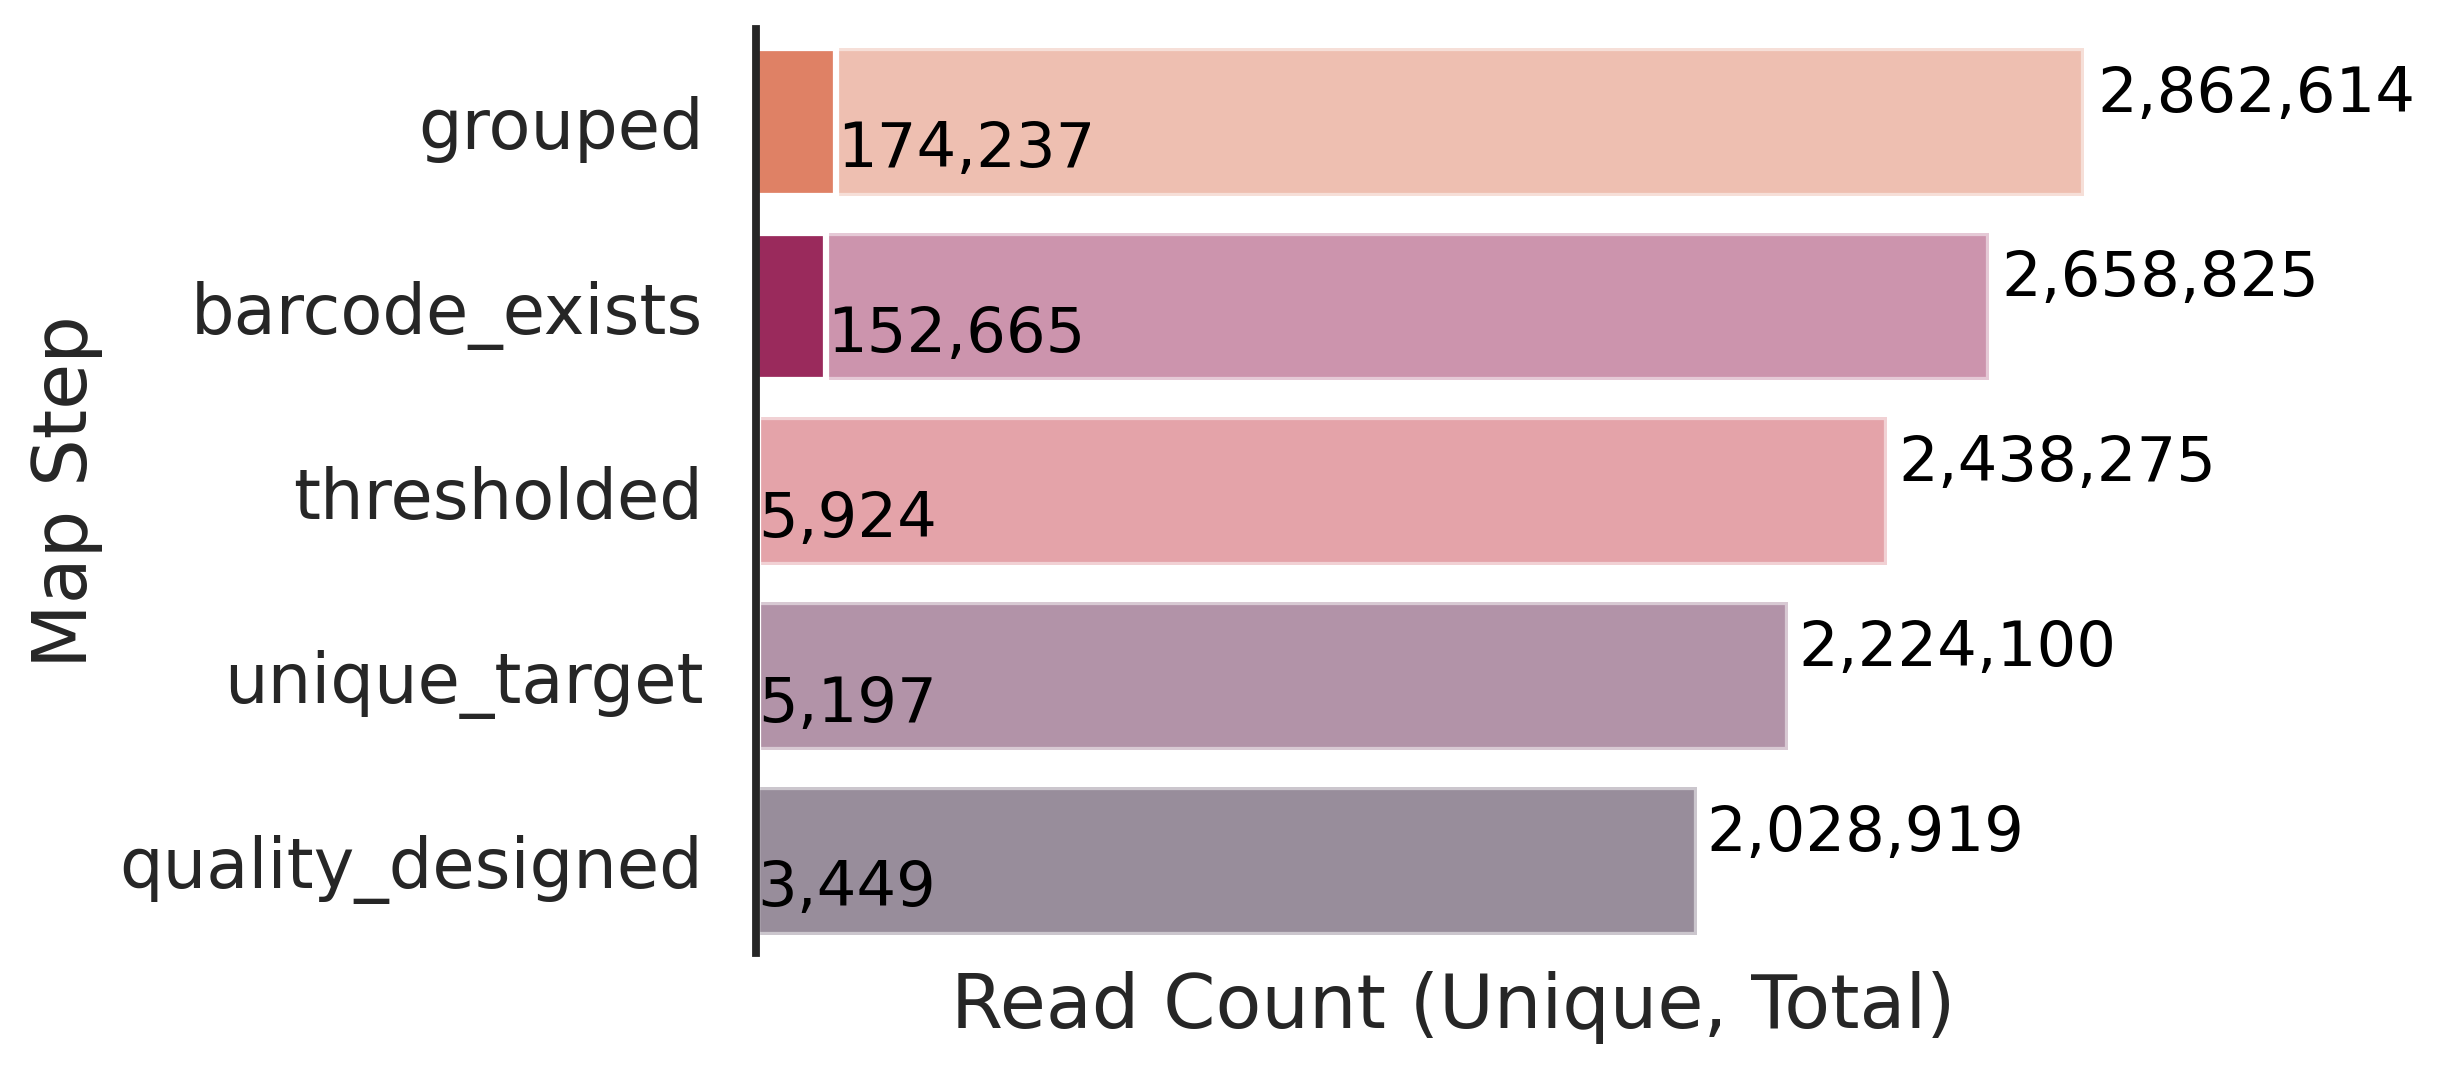

In [76]:
refiner.save_loss_table()
refiner.plot_loss(text_offset = -0.15)

In [78]:
quality_designed = refiner.get_map_df('quality_designed')
quality_designed

ADBC2    HawkBCs              RTBC  \
0     CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
1     GTCAGC  CCATTAACG  TGTAAAATGGGGCTGG   
2     GTACAA  CCATCGGTT  TTGCAGAATAGCTGCA   
3     TGGGAC  ACCGGATGT  CACAAAACGTGGCGCC   
4     CTAATA  ATCAGGACC  CAGGAAATCCCTCTAT   
...      ...        ...               ...   
3444  TGTAAC  AGGACAAGT  TGCAAGTTGTATGTAA   
3445  TCCTTT  CAATCAACC  CACGGGGGATATTAGC   
3446  CTATAC  CACTGACTA  AAGATATGAAAGCTAA   
3447  GATGAA  ACGTCGAGA  AGATGTCGACATATTA   
3448  ACTTAT  AACAACACC  TTAATATGACCACGAG   

                                                     AD  count  ADBC2_qual  \
0     GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...  11280        True   
1     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...   9331        True   
2     GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...   7305        True   
3     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   7166        True   
4     GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...   6466        True   
...                                                 ...    ...         ...   
3444  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3445  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3446  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3447  GCCTTCGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...      6        True   
3448  GCCCAGGACCTGGCCGCCGCCACCTTCCAGTTCGGCATTCCCTTCA...      6        True   

      HawkBCs_qual  RTBC_qual  AD_qual  Designed  
0             True       True     True         1  
1             True       True     True         1  
2             True       True     True         1  
3             True       True     True         1  
4             True       True     True         1  
...            ...        ...      ...       ...  
3444          True       True     True         1  
3445          True       True     True         1  
3446          True       True     True         1  
3447          True       True     True         1  
3448          True       True     True         1  

[3449 rows x 10 columns]

<Axes: ylabel='Count'>

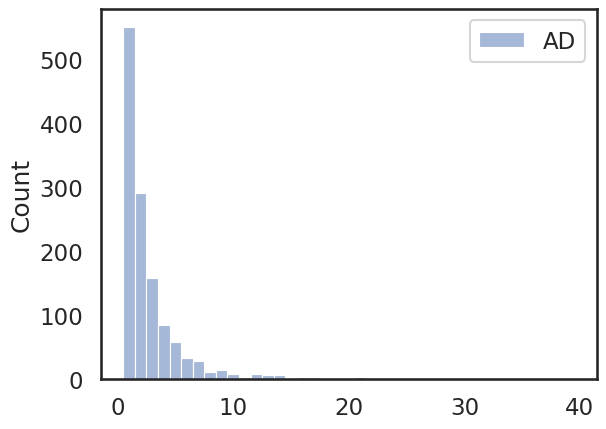

In [79]:
# How many ADs does a ADBC2 map back to?
sns.histplot(quality_designed[["ADBC2", "AD"]].drop_duplicates().groupby("ADBC2").count(), discrete = True)

<Axes: ylabel='Count'>

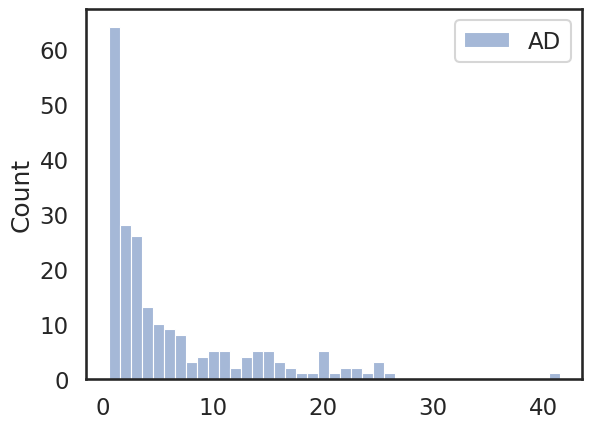

In [80]:
# How many ADs does a Hawk BC map back to?
sns.histplot(quality_designed[["HawkBCs", "AD"]].drop_duplicates().groupby("HawkBCs").count(), discrete = True)

In [ ]:
# try both barcodes
# hawkin first and then adbc2 next

In [ ]:
# wl_df = pd.read_csv("../../data/NKX2-2_whitelist_test_function/HawkBCs_whitelist.txt", sep="\t", header=None,
#                     names=["canonical", "collapsed", "total_count", "counts"])
# # Create a dict: key = original barcode, value = canonical barcode
# barcode_correction = {}

# for _, row in wl_df.iterrows():
#     # Add canonical itself
#     barcode_correction[row["canonical"]] = row["canonical"]
    
#     # Add all collapsed barcodes
#     if pd.notna(row["collapsed"]):
#         for bc in row["collapsed"].split(","):
#             barcode_correction[bc] = row["canonical"]

In [ ]:
# barcode_correction